# 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geopy.distance import geodesic
import matplotlib as mpl
import tqdm
from scipy.spatial.distance import cdist
from scipy.spatial import cKDTree
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기

In [2]:
train_data = pd.read_csv("/data/ephemeral/home/house/data/train.csv")
test_data = pd.read_csv("/data/ephemeral/home/house/data/test.csv")
sample_submission = pd.read_csv("/data/ephemeral/home/house/data/sample_submission.csv")
interest_data = pd.read_csv("/data/ephemeral/home/house/data/interestRate.csv")
park_data = pd.read_csv("/data/ephemeral/home/house/data/parkInfo.csv")
school_data = pd.read_csv("/data/ephemeral/home/house/data/schoolinfo.csv")
subway_data = pd.read_csv("/data/ephemeral/home/house/data/subwayInfo.csv")

In [3]:
train_data.head()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0


In [4]:
test_data.head()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age
0,0,84.961,202404,12,1,14,2016,36.965423,127.048779,8
1,1,59.900,202404,13,0,4,1997,36.963105,127.040678,27
2,2,39.270,202404,29,0,5,1990,36.957089,127.047449,34
3,3,39.270,202405,3,0,1,1990,36.957089,127.047449,34
4,4,46.980,202406,2,0,4,1990,36.957089,127.047449,34


In [5]:
sample_submission.head()

,index,deposit
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [6]:
interest_data.head()

,year_month,interest_rate
0,202405,3.56
1,202404,3.54
2,202403,3.59
3,202402,3.62
4,202401,3.66


In [7]:
park_data.head()

,latitude,longitude,area
0,37.509628,127.628406,856.0
1,37.508443,127.627414,847.0
2,37.493844,127.509326,1276.0
3,37.496021,127.408216,3300.0
4,37.496164,127.412326,394.0


In [8]:
school_data.head()

,schoolLevel,latitude,longitude
0,elementary,37.703889,127.540156
1,elementary,37.676874,127.600664
2,elementary,36.987340,129.399471
3,elementary,34.808753,126.456974
4,elementary,35.854580,127.003365


In [9]:
subway_data.head()

,latitude,longitude
0,37.759380,127.042292
1,37.541021,126.971300
2,37.529849,126.964561
3,37.514219,126.942454
4,37.513342,126.926382


In [10]:
train_data.dtypes

index                    int64
area_m2                float64
contract_year_month      int64
contract_day             int64
contract_type            int64
floor                    int64
built_year               int64
latitude               float64
longitude              float64
age                      int64
deposit                float64
dtype: object

# 결측치 확인

In [11]:
print("Train 데이터 결측치 확인:\n", train_data.isnull().sum())
print("Test 데이터 결측치 확인:\n", test_data.isnull().sum())
print("Subway 데이터 결측치 확인:\n", subway_data.isnull().sum())
print("Interest Rate 데이터 결측치 확인:\n", interest_data.isnull().sum())
print("School 데이터 결측치 확인:\n", school_data.isnull().sum())
print("Park 데이터 결측치 확인:\n", park_data.isnull().sum())

Train 데이터 결측치 확인:
 index                  0
area_m2                0
contract_year_month    0
contract_day           0
contract_type          0
floor                  0
built_year             0
latitude               0
longitude              0
age                    0
deposit                0
dtype: int64
Test 데이터 결측치 확인:
 index                  0
area_m2                0
contract_year_month    0
contract_day           0
contract_type          0
floor                  0
built_year             0
latitude               0
longitude              0
age                    0
dtype: int64
Subway 데이터 결측치 확인:
 latitude     0
longitude    0
dtype: int64
Interest Rate 데이터 결측치 확인:
 year_month       0
interest_rate    0
dtype: int64
School 데이터 결측치 확인:
 schoolLevel    0
latitude       0
longitude      0
dtype: int64
Park 데이터 결측치 확인:
 latitude     0
longitude    0
area         0
dtype: int64


# 데이터 병합

### interestRate.csv와 병합

In [12]:
# train_data와 interest_data 병합
train_data['contract_year_month'] = train_data['contract_year_month'].astype(str)
interest_data['year_month'] = interest_data['year_month'].astype(str)

# left join을 통해 금리 데이터를 병합
train_data = pd.merge(train_data, interest_data, how='left', left_on='contract_year_month', right_on='year_month')

# 중복된 열 제거
train_data.drop(columns=['year_month'], inplace=True)

In [13]:
train_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,interest_rate
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,1.78
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,1.26
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0,1.26
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0,1.68
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0,1.85
...,...,...,...,...,...,...,...,...,...,...,...,...
1801223,1801223,114.8126,202311,25,0,5,2010,37.528394,126.659398,13,39000.0,4.00
1801224,1801224,101.9088,202311,28,0,6,2010,37.528394,126.659398,13,38000.0,4.00
1801225,1801225,114.7900,202312,3,0,19,2010,37.528394,126.659398,13,37000.0,3.84
1801226,1801226,101.9088,202312,4,1,15,2010,37.528394,126.659398,13,34400.0,3.84


### subwayinfo.csv와 병합

In [14]:
def find_closest_distance_kdtree(train_data, loc_df):
    train_coords = train_data[['latitude', 'longitude']].values
    park_coords = loc_df[['latitude', 'longitude']].values
    tree = cKDTree(park_coords)
    distances, _ = tree.query(train_coords)
    return distances

In [15]:
train_data['closest_subway_distance'] = find_closest_distance_kdtree(train_data, subway_data)

In [16]:
train_data['closest_subway_distance']

0          0.007910
1          0.007910
2          0.007910
3          0.039234
4          0.018347
             ...   
1801223    0.016569
1801224    0.016569
1801225    0.016569
1801226    0.016569
1801227    0.016569
Name: closest_subway_distance, Length: 1801228, dtype: float64

### schoolinfo.csv와 병합

In [17]:
train_data['closest_school_distance'] = find_closest_distance_kdtree(train_data, school_data)

### parkinfo.csv와 병합

In [18]:
train_data['closest_park_distance'] = find_closest_distance_kdtree(train_data, park_data)

In [19]:
print(train_data[['closest_subway_distance', 'closest_school_distance', 'closest_park_distance']].head())

   closest_subway_distance  closest_school_distance  closest_park_distance
0                 0.007910                 0.001558               0.004779
1                 0.007910                 0.001558               0.004779
2                 0.007910                 0.001558               0.004779
3                 0.039234                 0.002046               0.001706
4                 0.018347                 0.015370               0.004277


# 데이터 분포 확인

### 지하철 위치 시각화

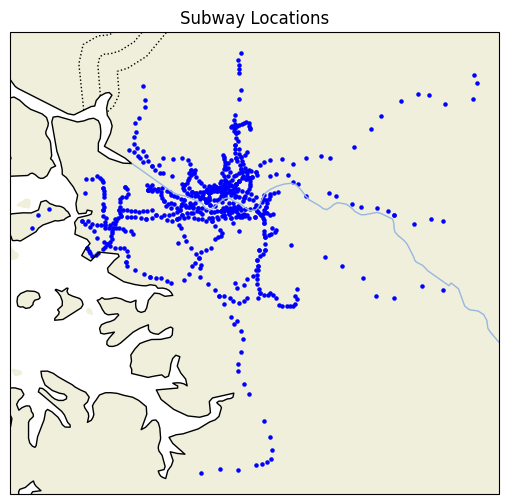

In [20]:
# 지하철 위치 시각화
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# 지도에 육지와 강을 추가
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.RIVERS)

# 지하철 위치 플로팅
gdf_subway = gpd.GeoDataFrame(subway_data, geometry=gpd.points_from_xy(subway_data.longitude, subway_data.latitude))
gdf_subway.plot(ax=ax, color='blue', markersize=5)

plt.title('Subway Locations')
plt.show()

In [ ]:
# 히스토그램
train_data.hist(bins=20, figsize=(14, 10), color='skyblue')
plt.tight_layout()
plt.show()

In [ ]:
# 박스플롯 (Outlier 확인)
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_data, palette='Set2')
plt.title('Boxplot of Variables')
plt.show()

# 상관관계 분석

In [ ]:
# 상관관계 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.2)
plt.title('Correlation Heatmap')
plt.show()

### 전세가와 금리 분포 확인 및 비교

In [ ]:
# 전세가 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(train_data['deposit'], kde=True, bins=30)
plt.title('Deposit Distribution')
plt.xlabel('Deposit')
plt.ylabel('Frequency')
plt.show()

# 금리 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(train_data['interest_rate'], kde=True, color='red', bins=30)
plt.title('Interest Rate Distribution')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.show()

### 계약 유형 별 전세가 비교

In [ ]:
# 계약 유형별 전세가 상자 그림
plt.figure(figsize=(10, 6))
sns.boxplot(x='contract_type', y='deposit', data=train_data)
plt.title('Deposit by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Deposit')
plt.show()

### 건축 연도 별 전세가 비교

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='built_year', y='deposit', data=train_data)
plt.title('Deposit by Built Year')
plt.xlabel('Built Year')
plt.ylabel('Deposit')
plt.show()

### 층수별 전세가 비교

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='floor', y='deposit', data=train_data)
plt.title('Deposit by Floor')
plt.xlabel('Floor')
plt.ylabel('Deposit')
plt.show()


### 면적과 전세가 비교

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='area_m2', y='deposit', data=train_data)
plt.title('Deposit by Area (m²)')
plt.xlabel('Area (m²)')
plt.ylabel('Deposit')
plt.show()


### latitude와 longitude를 활용한 전세가 지리적 분포 분석

In [ ]:
# 위도와 경도를 기반으로 한 전세가 분포 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='deposit', data=train_data, palette='coolwarm', alpha=0.6)
plt.title('Geographical Distribution of Deposit')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
# 전세가 데이터를 GeoDataFrame으로 변환
gdf_deposit = gpd.GeoDataFrame(train_data, geometry=gpd.points_from_xy(train_data.longitude, train_data.latitude))

# 전세가 값에 따라 색상을 지정하기 위한 컬러맵 설정
norm = plt.Normalize(vmin=gdf_deposit['deposit'].min(), vmax=gdf_deposit['deposit'].max())
cmap = plt.cm.get_cmap('coolwarm')

# 지도 생성
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# 지도에 육지, 해안선, 국경, 강 추가
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.RIVERS)

# 전세가에 따라 위치에 플로팅
gdf_deposit.plot(ax=ax, color=gdf_deposit['deposit'].apply(lambda x: cmap(norm(x))), markersize=5)

plt.title('Geographical Distribution of Deposit')
plt.show()

### 근접성 변수와 전세가의 관계

In [ ]:
# 지하철과의 거리 vs 전세가
plt.figure(figsize=(10, 6))
sns.scatterplot(x='closest_subway_distance', y='deposit', data=train_data)
plt.title('Deposit by Subway Distance')
plt.xlabel('Closest Subway Distance')
plt.ylabel('Deposit')
plt.show()

In [ ]:
# 학교와의 거리 vs 전세가
plt.figure(figsize=(10, 6))
sns.scatterplot(x='closest_school_distance', y='deposit', data=train_data)
plt.title('Deposit by School Distance')
plt.xlabel('Closest School Distance')
plt.ylabel('Deposit')
plt.show()

In [ ]:
# 공원과의 거리 vs 전세가
plt.figure(figsize=(10, 6))
sns.scatterplot(x='closest_park_distance', y='deposit', data=train_data)
plt.title('Deposit by Park Distance')
plt.xlabel('Closest Park Distance')
plt.ylabel('Deposit')
plt.show()

### 거리와 전세가의 관계
지하철, 학교, 공원 거리: 각 거리와 전세가 간의 관계를 시각화한 결과
- 거리가 가까울수록 전세가가 높아지는 경향 관찰
- 즉, 접근성이 좋은 위치일수록 더 높은 전세가를 형성할 가능성 존재

# 카테고리 변수 분석

In [ ]:
# 범주형 변수의 빈도수 확인 (가상 변수 'category'로 예시)
plt.figure(figsize=(8, 6))
sns.countplot(x='contract_type', data=train_data, palette='muted')
plt.title('Count of Categories')
plt.show()

### 계약 연월별 전세가 및 금리 추세

In [34]:
train_data['contract_year_month'] = pd.to_datetime(train_data['contract_year_month'], format='%Y%m')
monthly_avg = train_data.groupby('contract_year_month').agg({'deposit': 'mean', 'interest_rate': 'mean'}).reset_index()

In [ ]:
# 계약 연월별 전세가 및 금리 추세 시각화 개선
plt.figure(figsize=(12, 8))

# 첫 번째 y축: 전세가 (Deposit) 시각화
sns.lineplot(x='contract_year_month', y='deposit', data=monthly_avg, label='Average Deposit', color='blue')

# 두 번째 y축: 금리 (Interest Rate) 시각화
ax2 = plt.twinx()  # 두 번째 y축을 추가
sns.lineplot(x='contract_year_month', y='interest_rate', data=monthly_avg, label='Average Interest Rate', color='red', ax=ax2)

# 그래프 제목과 축 설정
plt.title('Interest Rate and Deposit Over Time')
plt.xlabel('Contract Year-Month')
plt.ylabel('Deposit (Blue)', color='blue')
ax2.set_ylabel('Interest Rate (Red)', color='red')

# x축 라벨을 일정 간격으로 보기 쉽게 회전
plt.xticks(rotation=45)

# X축 간격 설정: 라벨이 겹치지 않도록 일정 간격만 표시
plt.xticks(ticks=plt.gca().get_xticks()[::6])  # 라벨을 6개마다 한 번씩 표시

# Y축 범위 설정: 금리의 변화를 더 잘 보이도록 조정
ax2.set_ylim(monthly_avg['interest_rate'].min() - 0.5,monthly_avg['interest_rate'].max() + 0.5)

plt.legend(loc="upper left")
plt.show()

In [ ]:
# 시계열 분해 (계절성 및 트렌드 파악)
result = seasonal_decompose(monthly_avg['deposit'], model='additive', period=12)
result.plot()
plt.show()

- 전세가의 전반적인 상승 추세를 확인

## 상호작용 효과 탐색

In [ ]:
# 거리와 면적의 상호작용이 전세가에 미치는 영향
plt.figure(figsize=(10, 6))
sns.scatterplot(x='area_m2', y='closest_subway_distance', hue='deposit', data=train_data, palette='coolwarm')
plt.title('Deposit by Area and Subway Distance')
plt.xlabel('Area (m²)')
plt.ylabel('closest_subway_distance')
plt.show()

In [ ]:
min(train_data['closest_subway_distance'])

- 면적이 클수록 전세가가 증가하는 경향을 확인
- 지하철과의 거리가 가까울수록 deposit 증가하는 경향을 확인

### 지역별 분석

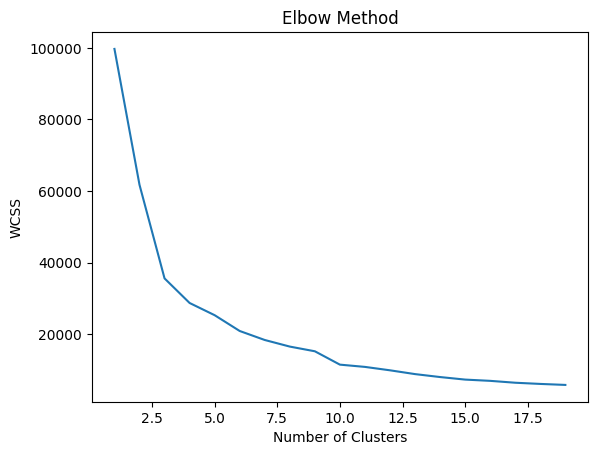

In [25]:
coords = train_data[['latitude', 'longitude']]
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(coords)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

### 엘보우 방법(Elbow Method)
- 클러스터 수에 따른 WCSS(Within-Cluster Sum of Squares)를 계산하고, 그래프에서 급격한 변화가 있는 지점을 찾음
- 이 지점이 적절한 클러스터 수
- 여기서는 3

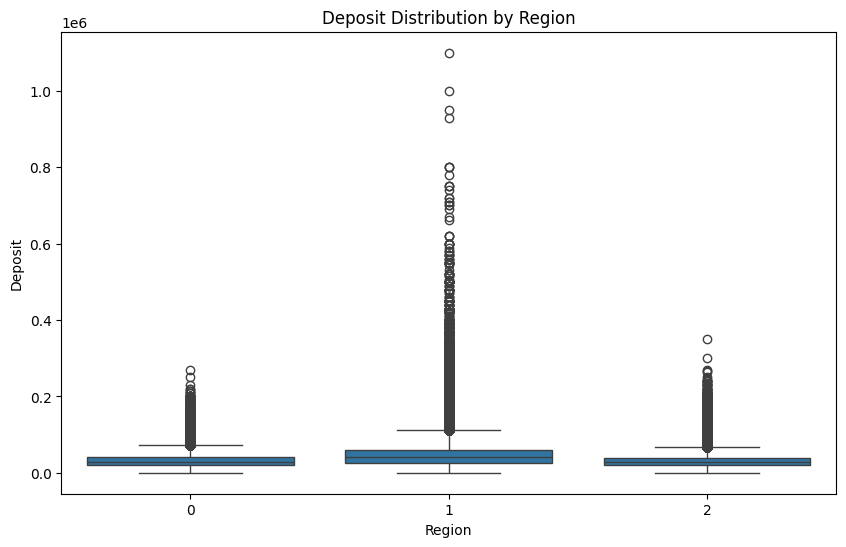

In [26]:
# 위도와 경도를 기반으로 KMeans 클러스터링
coords = train_data[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=3, random_state=42).fit(coords)
train_data['region'] = kmeans.labels_

# 지역별 전세가 분포 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='region', y='deposit', data=train_data)
plt.title('Deposit Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Deposit')
plt.show()

In [27]:
train_data['region']

0          0
1          0
2          0
3          0
4          0
          ..
1801223    2
1801224    2
1801225    2
1801226    2
1801227    2
Name: region, Length: 1801228, dtype: int32

# Feature Engineering

### 모델링에 필요한 라이브러리 임포트

In [28]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
import optuna

In [29]:
# 날짜 관련 피처 생성
train_data['contract_year_month'] = pd.to_datetime(train_data['contract_year_month'], format='%Y%m')
train_data['contract_year'] = train_data['contract_year_month'].dt.year
train_data['contract_month'] = train_data['contract_year_month'].dt.month
train_data['contract_season'] = train_data['contract_year_month'].dt.quarter

In [30]:
# 거리 로그 변환
train_data['log_subway_distance'] = np.log1p(train_data['closest_subway_distance'])
train_data['log_school_distance'] = np.log1p(train_data['closest_school_distance'])
train_data['log_park_distance'] = np.log1p(train_data['closest_park_distance'])

In [31]:
# 피처 및 타겟 설정
X = train_data[['area_m2', 'floor', 'built_year', 'region', 'latitude', 'longitude', 'log_subway_distance', 'log_school_distance', 'log_park_distance', 'contract_year', 'contract_month', 'contract_season']]
y = train_data['deposit']

In [32]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling

In [33]:
# 모델 정의
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    #'RandomForest': RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42),
    #'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'XGBoost': xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42)
}

### 기본 모델 적용 및 평가(K-Fold CV)

In [34]:
# KFold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [35]:
# 모델 학습 및 평가
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
    print(f"{name}: Mean MAE = {-scores.mean():.4f}, Std = {scores.std():.4f}")

LinearRegression: Mean MAE = 13355.1070, Std = 18.6425
Ridge: Mean MAE = 13353.1490, Std = 18.2633
Lasso: Mean MAE = 13355.3418, Std = 17.5372
XGBoost: Mean MAE = 5794.4353, Std = 24.5487
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 3

### 하이퍼파라미터 튜닝(Optuna)

In [ ]:
# def rf_objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 50, 300)
#     max_depth = trial.suggest_int('max_depth', 3, 20)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    
#     model = RandomForestRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         random_state=42
#     )
    
#     score = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
#     return -score.mean()

# rf_study = optuna.create_study(direction='minimize')
# rf_study.optimize(rf_objective, n_trials=50)
# print("Best parameters for RandomForest: ", rf_study.best_params)

In [38]:
def xgb_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        tree_method='gpu_hist',
        gpu_id=0,
        random_state=42
    )
    
    score = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
    return -score.mean()

xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(xgb_objective, n_trials=50)
print("Best parameters for XGBoost: ", xgb_study.best_params)

[I 2024-10-02 21:55:42,641] A new study created in memory with name: no-name-dbd22a3d-db91-4ee2-8d5d-cfd1eb62d621
[I 2024-10-02 21:56:58,711] Trial 0 finished with value: 4432.715970391704 and parameters: {'n_estimators': 268, 'max_depth': 13, 'learning_rate': 0.06252091312065629, 'subsample': 0.7573444855346996}. Best is trial 0 with value: 4432.715970391704.
[I 2024-10-02 21:57:06,158] Trial 1 finished with value: 5725.194029541592 and parameters: {'n_estimators': 298, 'max_depth': 5, 'learning_rate': 0.19701044554472372, 'subsample': 0.7051822800710918}. Best is trial 0 with value: 4432.715970391704.
[I 2024-10-02 21:57:11,461] Trial 2 finished with value: 6939.943585794429 and parameters: {'n_estimators': 213, 'max_depth': 3, 'learning_rate': 0.2897453603276558, 'subsample': 0.5966765289298558}. Best is trial 0 with value: 4432.715970391704.
[I 2024-10-02 21:57:19,662] Trial 3 finished with value: 5759.44480291908 and parameters: {'n_estimators': 271, 'max_depth': 6, 'learning_rate

KeyboardInterrupt: 

In [ ]:
def lgb_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', -1, 20) # -1 means no limit
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    num_leaves = trial.suggest_int('num_leaves', 2, 256)
    
    model = lgb.LGBMRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        random_state=42
    )
    
    score = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
    return -score.mean()

lgb_study = optuna.create_study(direction='minimize')
lgb_study.optimize(lgb_objective, n_trials=50)
print("Best parameters for LightGBM: ", lgb_study.best_params)

# 앙상블 모델(Voting Regressor)

In [41]:
xgb_tmp_best_params = {'n_estimators': 267, 'max_depth': 20, 'learning_rate': 0.03474061231102679, 'subsample': 0.7137831707849674}

In [42]:
## 최적화된 하이퍼파라미터를 반영한 모델 정의
#rf_best = RandomForestRegressor(**rf_study.best_params, random_state=42)
xgb_best = xgb.XGBRegressor(**xgb_tmp_best_params, tree_method='gpu_hist', gpu_id=0, random_state=42)
#lgb_best = lgb.LGBMRegressor(**lgb_study.best_params, random_state=42)
# voting_regressor = VotingRegressor(estimators=[
#     #('rf', rf_best),
#     ('xgb', xgb_best),
#     ('lgb', lgb_best)
# ])

voting_scores = cross_val_score(xgb_best, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
print(f"Voting Regressor: Mean MAE = {-voting_scores.mean():.4f}, Std = {voting_scores.std():.4f}")

Voting Regressor: Mean MAE = 4255.3975, Std = 6.8756


In [ ]:
model_names = ['XGBoost', 'LightGBM', 'Voting Regressor']
model_mae = [
    #-rf_study.best_value,
    xgb_study.best_value,
    lgb_study.best_value,
    -voting_scores.mean()
]

plt.figure(figsize=(10, 6))
plt.bar(model_names, model_mae, color=['green', 'orange', 'red'])
plt.ylabel('MAE')
plt.title('Model Comparison')
plt.show()

In [44]:
# 5. Voting Regressor로 예측 수행
xgb_best.fit(X_train, y_train)
y_pred = xgb_best.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Final Model MAE: {mae:.4f}")

Final Model MAE: 4126.2452


In [ ]:
# 6. 결과 분석 및 시각화
# 실제값과 예측값 비교
plt.figure(figsize=(10, 6))
plt.plot(y_test, y_pred, alpha=0.3, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Deposit')
plt.ylabel('Predicted Deposit')
plt.title('Actual vs Predicted Deposit')
plt.show()

# 실제 test.csv를 활용하여 output.csv 만들기

In [45]:
# test_data와 interest_data 병합
test_data['contract_year_month'] = test_data['contract_year_month'].astype(str)
interest_data['year_month'] = interest_data['year_month'].astype(str)

# left join을 통해 금리 데이터를 병합
test_data = pd.merge(test_data, interest_data, how='left', left_on='contract_year_month', right_on='year_month')

# 중복된 열 제거
test_data.drop(columns=['year_month'], inplace=True)

In [46]:
# 거리 관련
test_data['closest_subway_distance'] = find_closest_distance_kdtree(test_data, subway_data)
test_data['closest_school_distance'] = find_closest_distance_kdtree(test_data, school_data)
test_data['closest_park_distance'] = find_closest_distance_kdtree(test_data, park_data)

In [47]:
# 날짜 관련 피처 생성
test_data['contract_year_month'] = pd.to_datetime(test_data['contract_year_month'], format='%Y%m')
test_data['contract_year'] = test_data['contract_year_month'].dt.year
test_data['contract_month'] = test_data['contract_year_month'].dt.month
test_data['contract_season'] = test_data['contract_year_month'].dt.quarter

In [48]:
# 거리 로그 변환
test_data['log_subway_distance'] = np.log1p(test_data['closest_subway_distance'])
test_data['log_school_distance'] = np.log1p(test_data['closest_school_distance'])
test_data['log_park_distance'] = np.log1p(test_data['closest_park_distance'])

In [49]:
# 위도와 경도를 기반으로 KMeans 클러스터링
coords = test_data[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=3, random_state=42).fit(coords)
test_data['region'] = kmeans.labels_

In [50]:
# 피처 및 타겟 설정
final_test = test_data[['area_m2', 'floor', 'built_year', 'region', 'latitude', 'longitude', 'log_subway_distance', 'log_school_distance', 'log_park_distance', 'contract_year', 'contract_month', 'contract_season']]

In [51]:
voting_regressor_test_pred = xgb_best.predict(final_test)
sample_submission['deposit'] = voting_regressor_test_pred
sample_submission.to_csv('output.csv', index=False, encoding='utf-8-sig')